In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import scipy.stats as sp
#import statsmodels.api as sm
from pandas.stats.api import ols
from datetime import datetime
from pylab import rcParams
from scipy.signal import argrelextrema
import sys
import platform
import scipy
rcParams['figure.figsize'] = 15, 10
plt.rc('svg', fonttype = 'svgfont')

In [2]:
import wellapplication as wa

In [3]:
print("Operating System " + platform.system() + " " + platform.release())
print("Python Version " + str(sys.version))
print("Pandas Version " + str(pd.__version__))
print("Numpy Version " + str(np.__version__))
print("Well Application Version " + str(wa.__version__))
print("Scipy Version " +str(scipy.__version__))

Operating System Windows 7
Python Version 2.7.10 (default, May 23 2015, 09:40:32) [MSC v.1500 32 bit (Intel)]
Pandas Version 0.19.1
Numpy Version 1.11.2
Well Application Version 0.4.26
Scipy Version 0.17.0


In [4]:
import wellapplication.transport as wt

In [5]:
nw = wa.nwis("dv", "09266500", "sites")

connection successful


(729390.0, 729755.0)

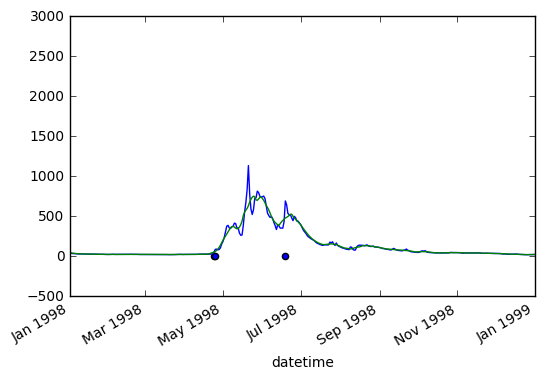

In [6]:
data = nw.data
data['perc_change'] = data.value.pct_change()
changepnts = data[data['perc_change'] >.5]
plt.figure()
y = changepnts.perc_change
x = changepnts.index

plt.scatter(x,y)
plt.plot(data.index, data.value)
data.value.rolling(10,center=True).mean().plot()

plt.xlim('1/1/1998','1/1/1999')


In [7]:
import sys
from numpy import NaN, Inf, arange, isscalar, asarray, array

def peakdet(v, delta, x = None):
    """
    Converted from MATLAB script at http://billauer.co.il/peakdet.html
    
    Returns two arrays
    
    function [maxtab, mintab]=peakdet(v, delta, x)
    %PEAKDET Detect peaks in a vector
    %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
    %        maxima and minima ("peaks") in the vector V.
    %        MAXTAB and MINTAB consists of two columns. Column 1
    %        contains indices in V, and column 2 the found values.
    %      
    %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
    %        in MAXTAB and MINTAB are replaced with the corresponding
    %        X-values.
    %
    %        A point is considered a maximum peak if it has the maximal
    %        value, and was preceded (to the left) by a value lower by
    %        DELTA.
    
    % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
    % This function is released to the public domain; Any use is allowed.
    
    """
    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))
    
    v = asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return array(maxtab), array(mintab)


In [8]:
datadir = 'U:/GWP/Groundwater/PowderMt/2017_UGA/'
datafile = 'northboundarydata.csv'

In [10]:
NBW

NameError: name 'NBW' is not defined

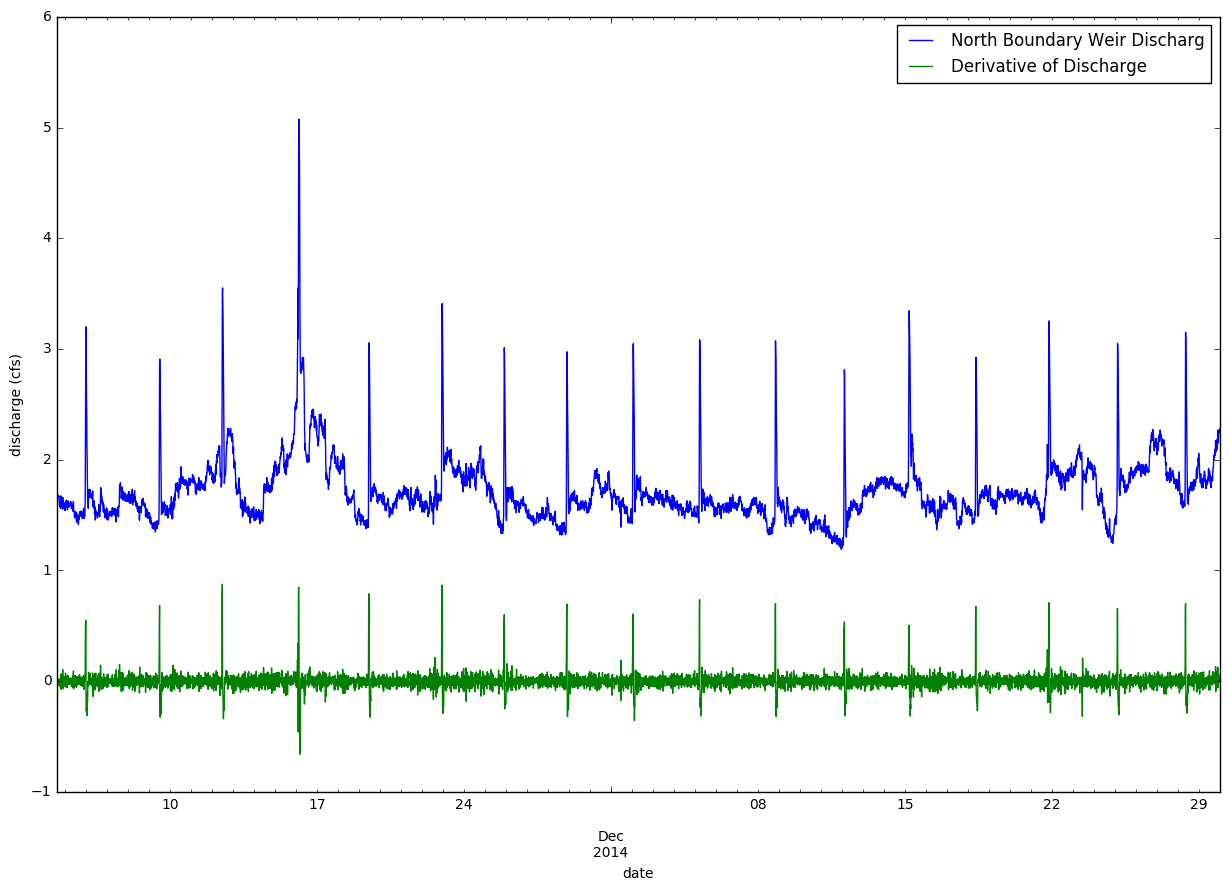

In [63]:
rcParams['figure.figsize'] = 15, 10
plt.rc('svg', fonttype = 'svgfont')

NBW = pd.read_csv(datadir + datafile,parse_dates=['dt'],index_col='dt')
NBW['LW Flow (cfs)'] = NBW['NB_LW_Q_cfs']
NBW = NBW[NBW.index<'12/30/2014']
NBW['NB_LW_Q_cfs'].plot(label='North Boundary Weir Discharg')
plt.grid()
NBW['dQ'] = NBW['NB_LW_Q_cfs'].diff()
NBW['dQ'].plot(label= 'Derivative of Discharge')
plt.xlabel('date')
plt.ylabel('discharge (cfs)')
plt.legend()
#plt.xlim('11/3/2014','11/26/2014')


In [19]:
def recession(df, q):
    '''
    Creates recession curve and modeled output to describe spring and streamflow recession.
    
    INPUT
    -----
    df = dataframe with spring discharge data
    Q = string indicating discharge field in df in units of gpm
    st = start date to examine data in [YYYY, MM, DD] format, where values are integers in an array

    
    OUTPUT
    ------
    popt = alpha value for recession curve
    x1 = days from start of recession
    x2 = dates of recession curve analysis
    y1 = points used for recession curve analysis
    y2 = recession curve values
    
    '''
    from datetime import timedelta
    def fitit(x,y,Q):
        from scipy.optimize import curve_fit
        def func(x, c):
            return Q*np.exp(-1*c*x)

        popt, pcov = curve_fit(func, x, y, p0=(1e-1))#, bounds = [0,40000], method='trf')
        return popt, pcov

    df2 = df.dropna(subset=[q])
    df2['cfd'] = df2[q]*28.3168#86400
    y1 = df2['cfd'].values
    x1 = df2.index.to_julian_date() - df2.index.to_julian_date()[0]
    popt1,pcov1 = fitit(x1, y1, y1[0])
    x2 = [df2.index[0] + timedelta(i) for i in x1]
    y2 = [y1[0]*np.exp(-1*popt1[0]*i) for i in x1]

    return popt1,x1,y1,x2,y2

In [82]:
peak, peakind, peakindbeg, peakindend =[],[],[],[]


for i in range(len(NBW['dQ'].values)):
    if NBW['dQ'].values[i] > 0.35:
        peak.append(NBW.index[i])
        peakind.append(i)
        peakindbeg.append(i-25)
        peakindend.append(i+25)

datebeg,dateend,datemax,maxflow,startflow, endflow, alpha = [],[],[],[],[],[],[]
for i in range(0,len(peak),2):
    g = NBW.iloc[peakindbeg[i]:peakind[i]]
    h = NBW.iloc[peakind[i]:peakindend[i]]
    begmin = argrelextrema(g['dQ'].values, np.less)[0]
    endmin = argrelextrema(h['LW Flow (cfs)'].values, np.less)[0]
    #print(g.index[begmin][-1]-h.index[endmin][0])
    j = NBW.loc[g.index[begmin][-1]:h.index[endmin][0],'LW Flow (cfs)'].idxmax()
    datemax.append(j)
    datebeg.append(g.index[begmin][-1])
    dateend.append(h.index[endmin][0])

-1 days +20:00:00
-1 days +20:30:00
-1 days +20:15:00
-1 days +21:00:00
-1 days +21:15:00
-1 days +20:15:00
-1 days +21:15:00
-1 days +20:45:00
-1 days +21:00:00
-1 days +20:45:00
-1 days +20:30:00
-1 days +20:30:00
-1 days +20:30:00
-1 days +20:30:00
-1 days +20:45:00
-1 days +21:15:00
-1 days +21:00:00
-1 days +20:30:00
-1 days +20:45:00


c:\users\paulinkenbrandt\documents\github\env\lib\site-packages\ipykernel\__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\paulinkenbrandt\documents\github\env\lib\site-packages\ipykernel\__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


9322.41481334
7387.7855875
8322.29245331
10157.1685173
8824.81703313
9456.73709121
9864.8587472
7935.1851735
9219.29636571
9797.89221863
9886.4486849
9104.70869659
7816.48914867
7816.48914867
9666.99643747
7718.52523262
7031.47275374
8539.16965856
8493.76695637


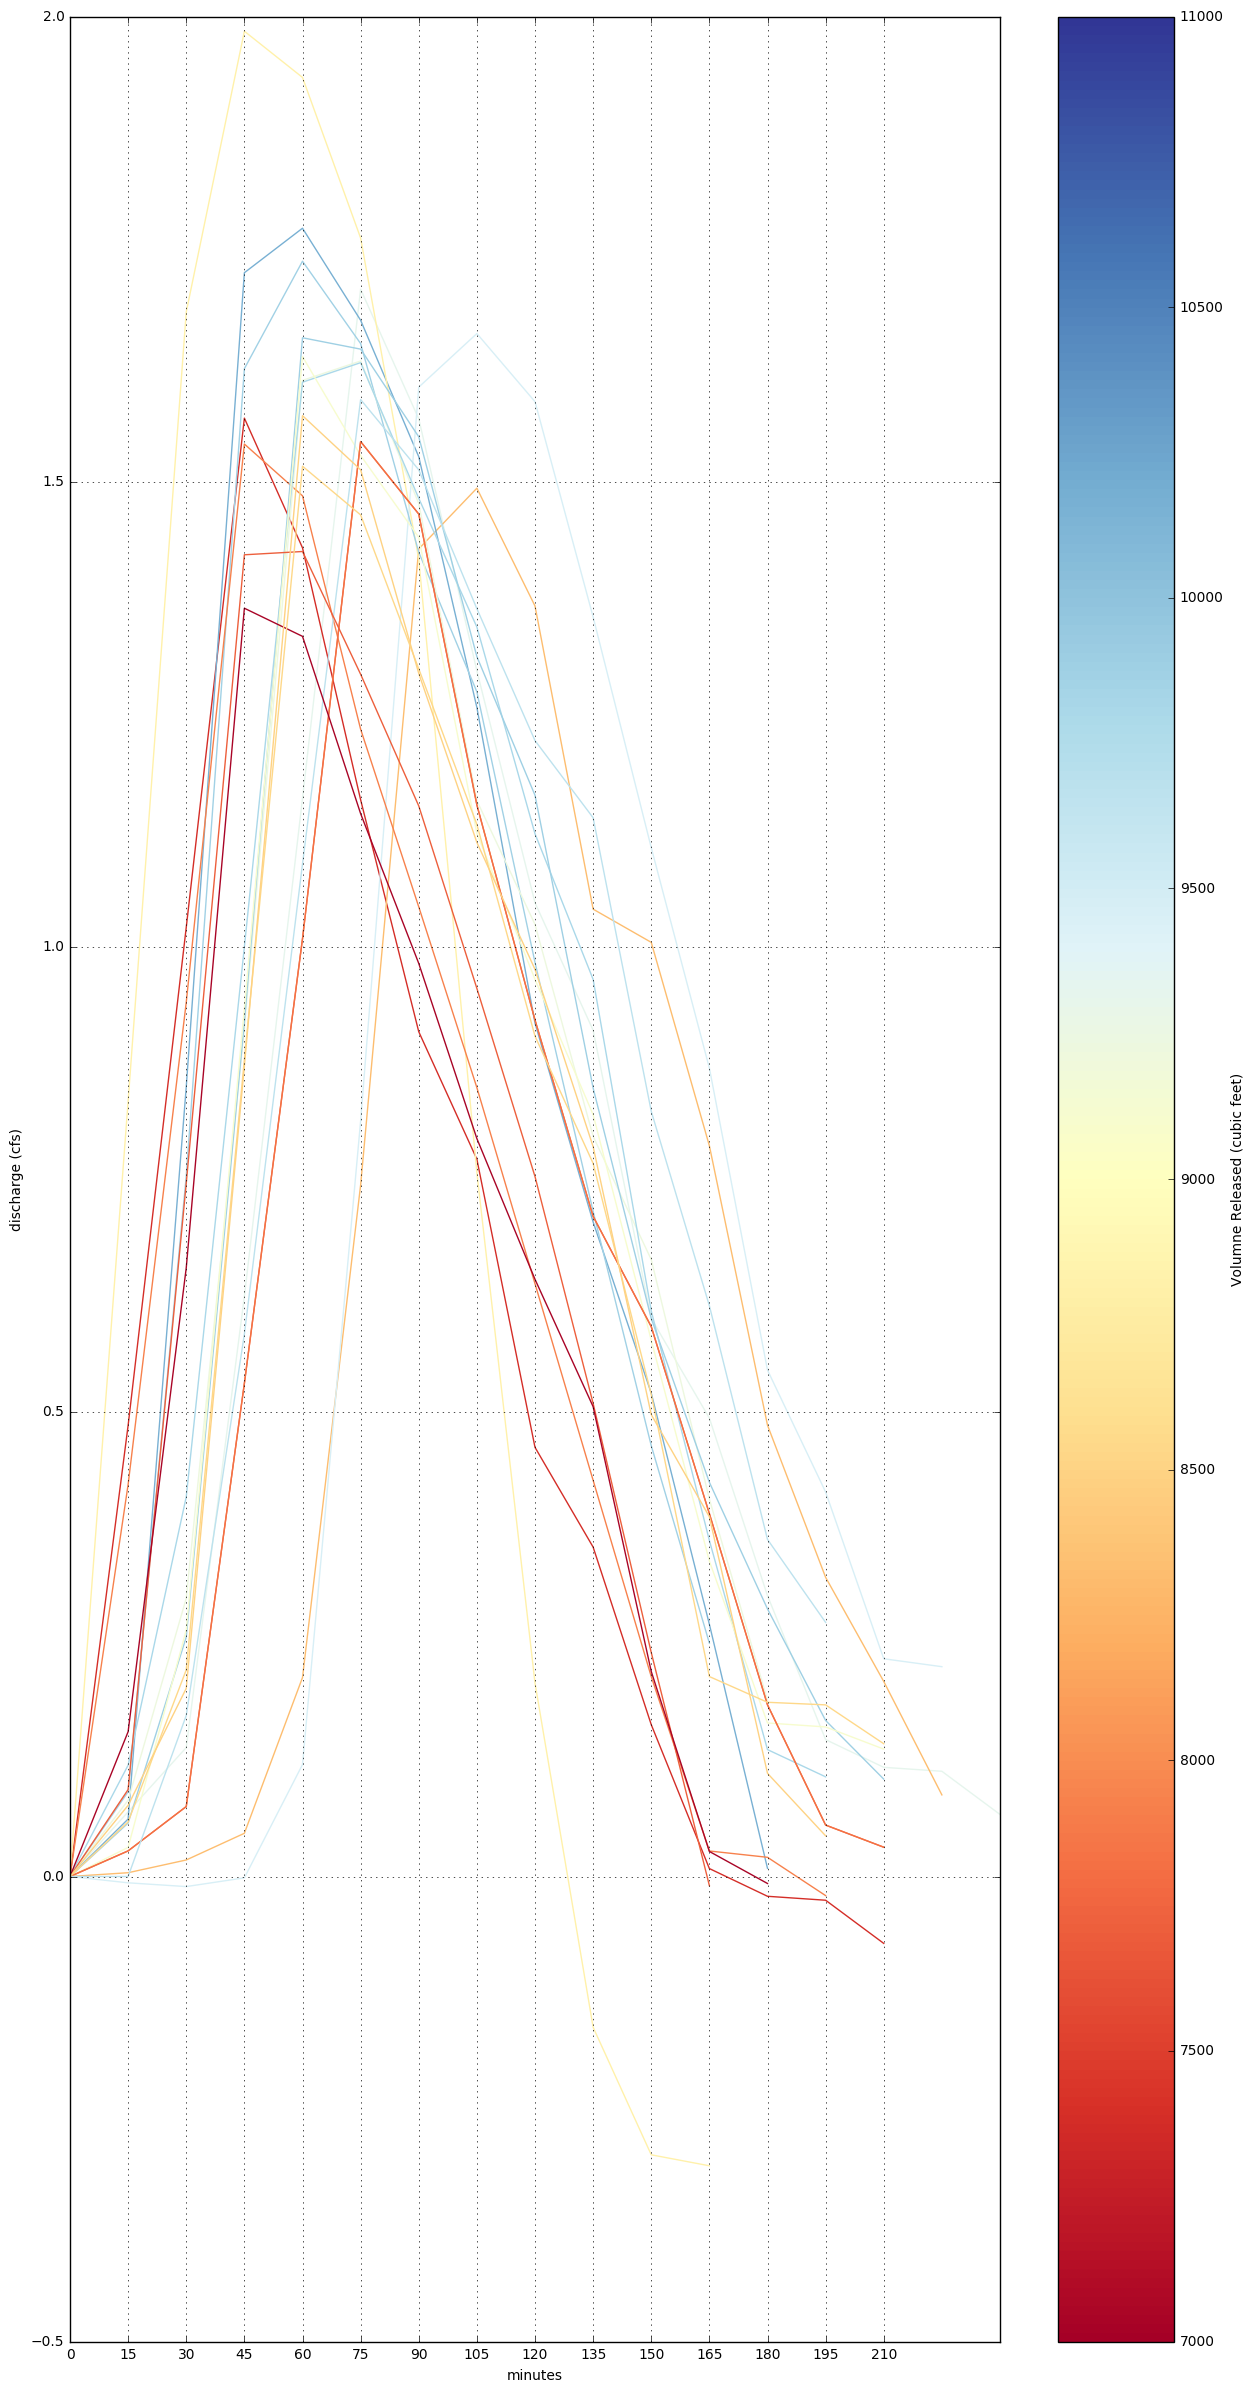

In [83]:
timeref = pd.DataFrame({'begin date':datebeg,'end date':dateend,'peak date':datemax})
timeref.reset_index(inplace=True)
timeref.set_index(['begin date'],inplace=True)
                        
import matplotlib as mpl
import matplotlib.cm as cm
w = timeref.index.to_julian_date()
cmap = plt.cm.get_cmap('RdYlBu')
norm = mpl.colors.Normalize(vmin=7000, vmax=11000)
#norm = mpl.colors.Normalize(vmin=w.min(), vmax=w.max())
m = cm.ScalarMappable(norm=norm, cmap=cmap)
m.set_array(range(7000,11000,(11000-7000)/len(datebeg)))
#m.set_array(w)


plt.figure()
vol,recess = [],[]
for i in range(len(datebeg)):


    subset = NBW.ix[datebeg[i]:dateend[i]]
    recset = NBW.ix[datemax[i]:dateend[i]]
    maxflow.append(subset['LW Flow (cfs)'].max())
    #print(subset['LW Flow (cfs)'])
    startflow.append(subset['LW Flow (cfs)'].values[0])
    endflow.append(subset['LW Flow (cfs)'].values[-1])

    subset['dflow'] = subset['LW Flow (cfs)'].apply(lambda x: (x-subset['LW Flow (cfs)'].values[0]),1)



    subset['vol'] = subset['LW Flow (cfs)'].apply(lambda x: (x-subset['LW Flow (cfs)'].values[0])*15.0*60.0,1)
    vol.append(subset['vol'].cumsum()[-1])
    plt.plot(range(len(subset['LW Flow (cfs)'].values)),
             subset['dflow'].values, color = m.to_rgba(subset['vol'].cumsum()[-1]))#w[i]
    print(subset['vol'].cumsum()[-1])
    mdate = pd.to_datetime(datemax[i])
    edate = pd.to_datetime(dateend[i])

    recs = recession(recset,'LW Flow (cfs)')
    alpha.append(recs[0][0])
    recess.append(recs)
plt.xticks(range(len(subset)+1),np.arange(0,(len(subset)+1)*15,15))
plt.xlabel('minutes')
plt.ylabel('discharge (cfs)')
plt.grid()
cbar = plt.colorbar(m)
#plt.xlim(0,5000)#x.max()+10000)
#plt.ylim(0,5000)#y.max()+10000)

cbar.set_label('Volumne Released (cubic feet)')


plt.savefig(datadir+'peakcomposite.pdf')
peaks = pd.DataFrame({'begin date':datebeg,'end date':dateend,'peak date':datemax,
                      'volume (cubic feet)':vol,'max flow (cfs)':maxflow,
                      'starting flow (cfs)':startflow,'ending flow (cfs)':endflow,'alpha':alpha})
peaks['time between peaks (days)'] = peaks['peak date'].diff()
peaks['time elapsed (hr)'] = peaks[['begin date','end date']].apply(lambda x: pd.to_timedelta(x[1]-x[0]).total_seconds()/3600,1)
peaks['time between peaks (hr)'] = peaks['time between peaks (days)'].apply(lambda x: pd.to_timedelta(x).total_seconds()/3600,1)
peaks['del flow (cfs)'] = peaks['max flow (cfs)'] - peaks['starting flow (cfs)']
peaks['volume (gal)'] = peaks['volume (cubic feet)']*7.48052

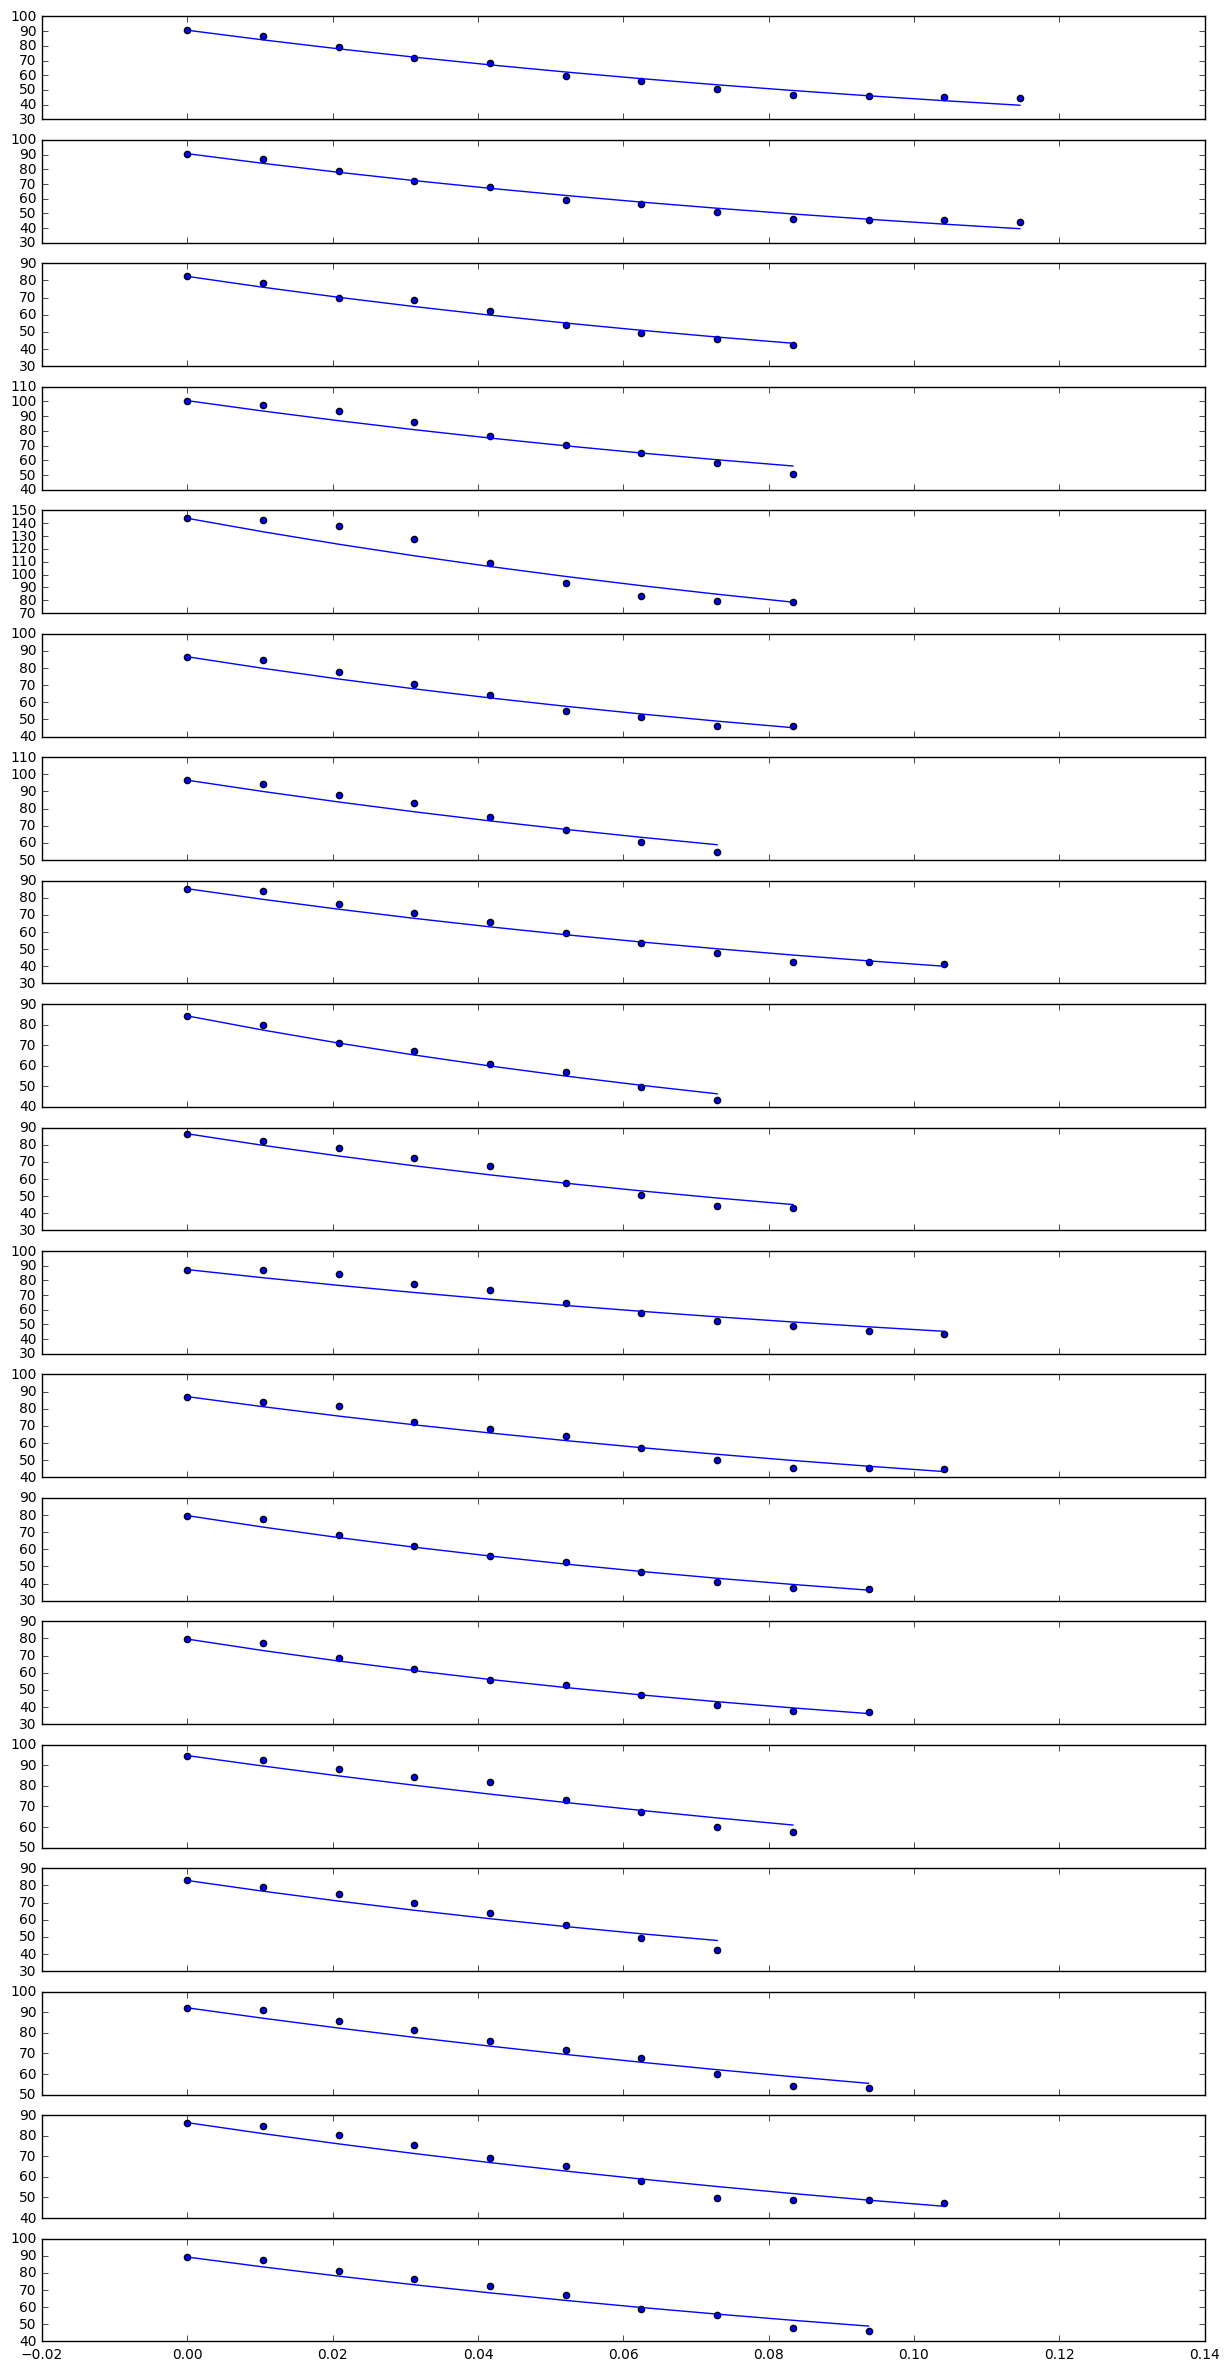

In [84]:
rcParams['figure.figsize'] = 15, 30
fig, ax = plt.subplots(len(recess),sharex=True)

for i in range(len(recess)):
    ax[i].plot(recess[i][1],recess[i][4])
    ax[i].scatter(recess[i][1],recess[i][2])

In [79]:
writer = pd.ExcelWriter(datadir+'peakSummary_V2.xlsx')
peaks.to_excel(writer,'peakDescription')
peaks.describe().to_excel(writer,'summaryStats')
writer.save()